In [9]:
# Cell 1: Setup and Installs
!pip install sentence-transformers pandas scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
import ast
import io
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (
    classification_report, accuracy_score, hamming_loss,
    jaccard_score, precision_recall_fscore_support
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)
print("Libraries installed and imported.")

Libraries installed and imported.


In [10]:
# Cell 2: Load Data from Colab Filesystem
import pandas as pd

file_path = '/content/English_long_formatted.csv'
# Make sure English_long_formatted.csv is uploaded to /content/

try:
    df_original = pd.read_csv(file_path) # Load into a new df name to keep it fresh
    print(f"Successfully loaded '{file_path}'")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Upload it first.")
    df_original = pd.DataFrame()

if not df_original.empty:
    if 'Unnamed: 0' in df_original.columns:
        df_original = df_original.drop(columns=['Unnamed: 0'])
    elif df_original.columns[0] == '' and len(df_original.columns) > 1:
        df_original = df_original.rename(columns={'': 'original_index'}).drop(columns=['original_index'])

    df = df_original.copy() # Work with a copy for this notebook's specific preprocessing
    print("\nDataFrame Head:")
    print(df.head(2))
    print("\nDataFrame Info:")
    df.info()
else:
    print("\nDataFrame is empty.")

Successfully loaded '/content/English_long_formatted.csv'

DataFrame Head:
              Scenario_id              Annotator_id  \
0  long_id_0_MJI_Emotions  6600f13d42341b1aae3e20ae   
1  long_id_0_MJI_Emotions  5db31089a1f8d3000c10a6c5   

                                            Scenario  \
0  A manager is considering two candidates for a ...   
1  A manager is considering two candidates for a ...   

                                    Possible_actions  Selected_action  \
0  ['Promote the Highly Qualified Candidate, pote...                2   
1  ['Promote the Highly Qualified Candidate, pote...                2   

                                              Reason  \
0  You can train this employee on necessary skill...   
1  The potential for disruption to the workforce ...   

                                         Consequence       Action_criteria  \
0  The outspoken employee will likely be very ups...  ['2', '4', '4', '5']   
1  The need for skill development will probab

In [11]:
# Cell 3: Initial Preprocessing (Parsing Lists, Target Variable Preparation)

def safe_literal_eval_new(val):
    try:
        return ast.literal_eval(val)
    except:
        return val

if not df.empty:
    df['Possible_actions'] = df['Possible_actions'].apply(safe_literal_eval_new)
    df['Contributing_emotion'] = df['Contributing_emotion'].apply(safe_literal_eval_new)
    df['Moral_values_dict'] = df['Moral_values'].apply(safe_literal_eval_new)
    df['Cultural_values_dict'] = df['Cultural_values'].apply(safe_literal_eval_new)

    # --- Target Variable 1: Selected_action_binary ---
    # Original is 1 or 2, convert to 0 or 1
    df['Selected_action_binary'] = df['Selected_action'].apply(lambda x: x - 1)

    # --- Target Variable 2: Contributing_emotion ---
    # Handle 'None' and ensure it's a list of strings
    def process_emotions(emotions_list):
        if isinstance(emotions_list, list):
            # Filter out 'None' string if it's the only element or among others
            cleaned_emotions = [str(e) for e in emotions_list if str(e).lower() != 'none' and pd.notna(e)]
            return cleaned_emotions if cleaned_emotions else ['no_emotion_stated'] # Use a placeholder if empty
        elif pd.isna(emotions_list) or str(emotions_list).lower() == 'none':
            return ['no_emotion_stated'] # Placeholder for NaN or 'None' string
        return [str(emotions_list)] # If it's a single string emotion

    df['Contributing_emotion_list'] = df['Contributing_emotion'].apply(process_emotions)

    # Fit MultiLabelBinarizer for emotions
    mlb_emotion = MultiLabelBinarizer()
    y_emotion_encoded = mlb_emotion.fit_transform(df['Contributing_emotion_list'])
    emotion_target_cols = mlb_emotion.classes_.tolist()
    print(f"Emotion classes for MLB: {emotion_target_cols}")

    # Add encoded emotions back to df for easier splitting (optional, could also keep y_emotion_encoded separate)
    for i, emotion_col in enumerate(emotion_target_cols):
        df[f"emotion_{emotion_col}"] = y_emotion_encoded[:, i]

    # Create Selected_action_text (will be an input feature)
    df['Selected_action_text'] = df.apply(
        lambda row: row['Possible_actions'][row['Selected_action_binary']] # Use 0-indexed binary action
        if isinstance(row['Possible_actions'], list) and 0 <= row['Selected_action_binary'] < len(row['Possible_actions'])
        else "",
        axis=1
    )

    # Text features for embedding (common to all 3 models)
    text_input_cols = ['Scenario', 'Selected_action_text', 'Annotator_self_description']
    for col in text_input_cols:
        df[col] = df[col].fillna("").astype(str)

    # Numerical Moral Values (for Models 2 & 3)
    moral_value_keys = ['Care', 'Equality', 'Proportionality', 'Loyalty', 'Authority', 'Purity']
    for key in moral_value_keys:
        df[f'moral_{key}'] = df['Moral_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    # Numerical Cultural Values (for Model 3)
    cultural_value_keys = ['Power Distance', 'Individualism', 'Masculinity', 'Uncertainty Avoidance', 'Long Term Orientation', 'Indulgence vs Restraint']
    for key in cultural_value_keys:
        df[f'cultural_{key}'] = df['Cultural_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    # --- Define target columns ---
    target_action_col = ['Selected_action_binary']
    target_emotion_cols = [f"emotion_{col}" for col in emotion_target_cols]

    # --- Handle potential NaNs introduced by parsing moral/cultural values if dicts were incomplete ---
    cols_to_check_for_nan_inputs = [f'moral_{k}' for k in moral_value_keys] + [f'cultural_{k}' for k in cultural_value_keys]
    df_cleaned = df.dropna(subset=cols_to_check_for_nan_inputs).copy() # Drop rows if any MORAL/CULTURAL input is NaN
                                                                     # Assuming targets (action/emotion) are always present
    print(f"Shape of df after parsing and initial NaN drop (if any from moral/cultural inputs): {df_cleaned.shape}")

    df = df_cleaned # Work with the cleaned dataframe

    print(df[['Scenario_id', 'Selected_action_binary'] + target_emotion_cols].head())
else:
    print("DataFrame is empty, skipping preprocessing.")

Emotion classes for MLB: ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'no_emotion_stated', 'scale_1', 'scale_2', 'scale_3', 'scale_4', 'scale_5']
Shape of df after parsing and initial NaN drop (if any from moral/cultural inputs): (582, 44)
              Scenario_id  Selected_action_binary  emotion_Anger  \
0  long_id_0_MJI_Emotions                       1              0   
1  long_id_0_MJI_Emotions                       1              0   
2  long_id_0_MJI_Emotions                       0              0   
3            Reddit_id_50                       1              0   
4            Reddit_id_50                       0              0   

   emotion_Anticipation  emotion_Disgust  emotion_Fear  emotion_Joy  \
0                     0                0             0            0   
1                     1                0             0            0   
2                     1                0             0            1   
3                     1     

In [12]:
# Cell 4: Initialize Embedding Model
embedding_model_name = 'all-MiniLM-L6-v2'
sbert_model = SentenceTransformer(embedding_model_name)
print(f"Sentence Transformer model '{embedding_model_name}' loaded.")

Sentence Transformer model 'all-MiniLM-L6-v2' loaded.


In [13]:
# Cell 5: Generate Text Embeddings (Common for all models)

if not df.empty:
    embeddings_list_text = []
    for col in text_input_cols:
        print(f"Generating embeddings for: {col}")
        texts_to_embed = df[col].astype(str).tolist()
        embeddings = sbert_model.encode(texts_to_embed, show_progress_bar=True)
        embeddings_list_text.append(embeddings)

    X_text_embeddings = np.concatenate(embeddings_list_text, axis=1)
    print(f"\nShape of X_text_embeddings: {X_text_embeddings.shape}")
else:
    X_text_embeddings = np.array([])
    print("Skipping embedding generation as DataFrame is empty.")

Generating embeddings for: Scenario


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Selected_action_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Annotator_self_description


Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Shape of X_text_embeddings: (582, 1152)


## Model 1

In [14]:
# Cell 6: Prepare Data for Model 1

if not df.empty:
    # Model 1 Inputs: Just text embeddings
    X_model1 = X_text_embeddings

    # Model 1 Targets
    y_action_model1 = df[target_action_col].values
    y_emotion_model1 = df[target_emotion_cols].values # These are already binarized

    print("Model 1 Data Shapes:")
    print(f"X_model1 shape: {X_model1.shape}")
    print(f"y_action_model1 shape: {y_action_model1.shape}")
    print(f"y_emotion_model1 shape: {y_emotion_model1.shape}")

    X_train1, X_test1, y_train_action1, y_test_action1, y_train_emotion1, y_test_emotion1 = train_test_split(
        X_model1, y_action_model1, y_emotion_model1, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 1 data prep.")

Model 1 Data Shapes:
X_model1 shape: (582, 1152)
y_action_model1 shape: (582, 1)
y_emotion_model1 shape: (582, 14)


In [15]:
# Cell 7: Build and Train Model 1 (CORRECTED EarlyStopping)

if not df.empty:
    input_dims_model1 = X_train1.shape[1]
    num_emotion_classes = y_train_emotion1.shape[1]

    # Input Layer
    input_layer1 = Input(shape=(input_dims_model1,), name='input_model1')

    # Shared Dense Layers
    x = Dense(128, activation='relu', name='shared_dense1_m1')(input_layer1)
    x = Dropout(0.3, name='shared_dropout1_m1')(x)
    x = Dense(64, activation='relu', name='shared_dense2_m1')(x)
    x = Dropout(0.3, name='shared_dropout2_m1')(x)

    # Output Head 1: Selected Action (Binary Classification)
    output_action1 = Dense(1, activation='sigmoid', name='action_output_m1')(x)

    # Output Head 2: Contributing Emotion (Multi-label Classification)
    output_emotion1 = Dense(num_emotion_classes, activation='sigmoid', name='emotion_output_m1')(x)

    model1 = Model(inputs=input_layer1, outputs=[output_action1, output_emotion1], name="Model1_Choice_Emotion")

    model1.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'action_output_m1': 'binary_crossentropy', 'emotion_output_m1': 'binary_crossentropy'},
        metrics={'action_output_m1': 'accuracy', 'emotion_output_m1': 'accuracy'}
    )
    model1.summary()

    print("\nTraining Model 1...")
    # --- CORRECTED EarlyStopping ---
    early_stopping1 = tf.keras.callbacks.EarlyStopping(
        monitor='val_action_output_m1_loss',
        patience=10,
        restore_best_weights=True,
        mode='min' # Explicitly tell Keras to minimize this loss
    )

    history1 = model1.fit(
        X_train1,
        {'action_output_m1': y_train_action1, 'emotion_output_m1': y_train_emotion1},
        epochs=50,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping1], # Use the corrected callback
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 1 training.")

Model: "Model1_Choice_Emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_model1        │ (None, 1152)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense1_m1    │ (None, 128)       │    147,584 │ input_model1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout1_m1  │ (None, 128)       │          0 │ shared_dense1_m1… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense2_m1    │ (None, 64)        │      8,256 │ shared_dropout1_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout2_m1  │ (None, 64)        │          0 │ shared_dense2_m1… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_output_m1    │ (None, 1)         │         65 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output_m1   │ (None, 14)        │        910 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 156,815 (612.56 KB)

 Trainable params: 156,815 (612.56 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 1...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - action_output_m1_accuracy: 0.5416 - action_output_m1_loss: 0.6889 - emotion_output_m1_accuracy: 0.0605 - emotion_output_m1_loss: 0.6813 - loss: 1.3706 - val_action_output_m1_accuracy: 0.5143 - val_action_output_m1_loss: 0.6886 - val_emotion_output_m1_accuracy: 0.1286 - val_emotion_output_m1_loss: 0.6105 - val_loss: 1.2950
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - action_output_m1_accuracy: 0.6305 - action_output_m1_loss: 0.6617 - emotion_output_m1_accuracy: 0.1080 - emotion_output_m1_loss: 0.5865 - loss: 1.2489 - val_action_output_m1_accuracy: 0.6143 - val_action_output_m1_loss: 0.6740 - val_emotion_output_m1_accuracy: 0.1714 - val_emotion_output_m1_loss: 0.4590 - val_loss: 1.1291
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - action_output_m1_accuracy: 0.6104 - action_output_m1_loss: 0.6492 - emotion_output_m1_accuracy: 0.1134 - emotion_output_m1_loss: 0.4527 - loss: 1.1023 - val_action_output_m


Evaluating Model 1...
Model 1 - Overall Loss: 0.9608
Model 1 - Action Prediction Loss: 0.6656, Accuracy: 0.7094
Model 1 - Emotion Prediction Loss: 0.3058, Accuracy (subset): 0.1538
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Model 1 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.74      0.67      0.70        60
    Action 1       0.68      0.75      0.72        57

    accuracy                           0.71       117
   macro avg       0.71      0.71      0.71       117
weighted avg       0.71      0.71      0.71       117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Model 1 - Emotion Multi-label Report (per class):
                   precision    recall  f1-score   support

            Anger       0.00      0.00      0.00        12
     Anticipation       0.00      0.00      0.00        34
          Disgust       0.00      0.00      0.00        13
             Fear       0.00      0.00      0.00        31
              Joy       0.0

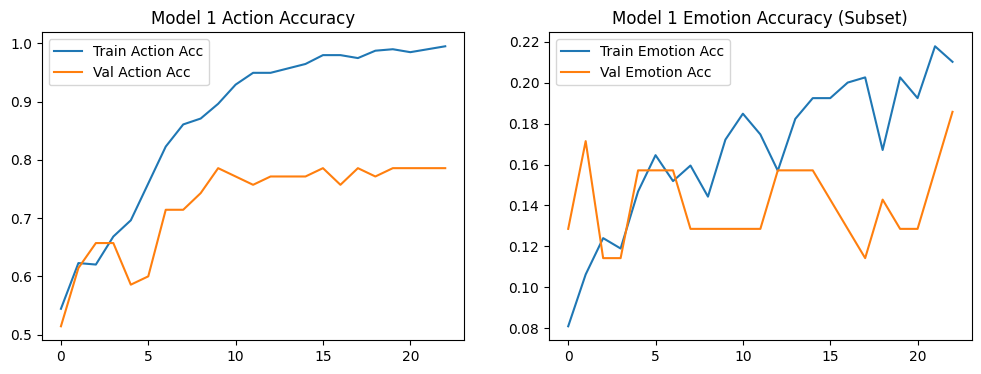

In [16]:
# Cell 8: Evaluate Model 1
if not df.empty and 'model1' in locals():
    print("\nEvaluating Model 1...")
    loss1, action_loss1, emotion_loss1, action_acc1, emotion_acc1 = model1.evaluate(
        X_test1,
        [y_test_action1, y_test_emotion1],
        verbose=0
    )
    print(f"Model 1 - Overall Loss: {loss1:.4f}")
    print(f"Model 1 - Action Prediction Loss: {action_loss1:.4f}, Accuracy: {action_acc1:.4f}")
    print(f"Model 1 - Emotion Prediction Loss: {emotion_loss1:.4f}, Accuracy (subset): {emotion_acc1:.4f}")

    # Detailed classification report for action
    y_pred_action1_probs = model1.predict(X_test1)[0]
    y_pred_action1_classes = (y_pred_action1_probs > 0.5).astype(int)
    print("\nModel 1 - Action Classification Report:")
    print(classification_report(y_test_action1, y_pred_action1_classes, target_names=['Action 0', 'Action 1']))

    # Detailed metrics for emotions
    y_pred_emotion1_probs = model1.predict(X_test1)[1]
    y_pred_emotion1_classes = (y_pred_emotion1_probs > 0.5).astype(int)
    print("\nModel 1 - Emotion Multi-label Report (per class):")
    # Note: target_names for emotions comes from mlb_emotion.classes_
    print(classification_report(y_test_emotion1, y_pred_emotion1_classes, target_names=emotion_target_cols, zero_division=0))
    print(f"Model 1 - Emotion Hamming Loss: {hamming_loss(y_test_emotion1, y_pred_emotion1_classes):.4f}")
    print(f"Model 1 - Emotion Jaccard Score (samples): {jaccard_score(y_test_emotion1, y_pred_emotion1_classes, average='samples'):.4f}")

    # Plotting (optional, can be extensive for multi-output)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history1.history['action_output_m1_accuracy'], label='Train Action Acc')
    plt.plot(history1.history['val_action_output_m1_accuracy'], label='Val Action Acc')
    plt.title('Model 1 Action Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history1.history['emotion_output_m1_accuracy'], label='Train Emotion Acc')
    plt.plot(history1.history['val_emotion_output_m1_accuracy'], label='Val Emotion Acc')
    plt.title('Model 1 Emotion Accuracy (Subset)')
    plt.legend()
    plt.show()
else:
    print("Skipping Model 1 evaluation.")

## Model 2

In [17]:
# Cell 9: Prepare Data for Model 2

if not df.empty:
    moral_input_cols = [f'moral_{key}' for key in moral_value_keys]
    X_moral_features_raw = df[moral_input_cols].values

    scaler_moral = StandardScaler()
    X_moral_scaled = scaler_moral.fit_transform(X_moral_features_raw)

    # Model 2 Inputs: Text embeddings + Scaled Moral Values
    X_model2 = np.concatenate([X_text_embeddings, X_moral_scaled], axis=1)

    # Model 2 Targets (same as Model 1)
    y_action_model2 = df[target_action_col].values
    y_emotion_model2 = df[target_emotion_cols].values

    print("\nModel 2 Data Shapes:")
    print(f"X_model2 shape: {X_model2.shape}") # Should be X_text_embeddings.shape[1] + 6
    print(f"y_action_model2 shape: {y_action_model2.shape}")
    print(f"y_emotion_model2 shape: {y_emotion_model2.shape}")

    X_train2, X_test2, y_train_action2, y_test_action2, y_train_emotion2, y_test_emotion2 = train_test_split(
        X_model2, y_action_model2, y_emotion_model2, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 2 data prep.")


Model 2 Data Shapes:
X_model2 shape: (582, 1158)
y_action_model2 shape: (582, 1)
y_emotion_model2 shape: (582, 14)


In [18]:
# Cell 10: Build and Train Model 2 (CORRECTED EarlyStopping)

if not df.empty:
    input_dims_model2 = X_train2.shape[1]
    num_emotion_classes = y_train_emotion2.shape[1] # Should be same as model 1

    input_layer2 = Input(shape=(input_dims_model2,), name='input_model2')

    # Shared Dense Layers (can adjust if desired for this model)
    x = Dense(160, activation='relu', name='shared_dense1_m2')(input_layer2) # Slightly larger
    x = Dropout(0.35, name='shared_dropout1_m2')(x)
    x = Dense(80, activation='relu', name='shared_dense2_m2')(x) # Slightly larger
    x = Dropout(0.35, name='shared_dropout2_m2')(x)

    output_action2 = Dense(1, activation='sigmoid', name='action_output_m2')(x)
    output_emotion2 = Dense(num_emotion_classes, activation='sigmoid', name='emotion_output_m2')(x)

    model2 = Model(inputs=input_layer2, outputs=[output_action2, output_emotion2], name="Model2_Choice_Emotion_Moral")

    model2.compile(
        optimizer=Adam(learning_rate=0.0008), # Example: different LR
        loss={'action_output_m2': 'binary_crossentropy', 'emotion_output_m2': 'binary_crossentropy'},
        metrics={'action_output_m2': 'accuracy', 'emotion_output_m2': 'accuracy'}
    )
    model2.summary()

    print("\nTraining Model 2...")
    # --- CORRECTED EarlyStopping for Model 2 ---
    early_stopping2 = tf.keras.callbacks.EarlyStopping(
        monitor='val_action_output_m2_loss',
        patience=12,
        restore_best_weights=True,
        mode='min' # Explicitly set mode to minimize loss
    )

    history2 = model2.fit(
        X_train2,
        {'action_output_m2': y_train_action2, 'emotion_output_m2': y_train_emotion2},
        epochs=60,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping2], # Use the corrected callback
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 2 training.")

Model: "Model2_Choice_Emotion_Moral"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_model2        │ (None, 1158)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense1_m2    │ (None, 160)       │    185,440 │ input_model2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout1_m2  │ (None, 160)       │          0 │ shared_dense1_m2… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense2_m2    │ (None, 80)        │     12,880 │ shared_dropout1_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout2_m2  │ (None, 80)        │          0 │ shared_dense2_m2… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_output_m2    │ (None, 1)         │         81 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output_m2   │ (None, 14)        │      1,134 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 199,535 (779.43 KB)

 Trainable params: 199,535 (779.43 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 2...
Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - action_output_m2_accuracy: 0.4875 - action_output_m2_loss: 0.6976 - emotion_output_m2_accuracy: 0.0432 - emotion_output_m2_loss: 0.6798 - loss: 1.3774 - val_action_output_m2_accuracy: 0.5286 - val_action_output_m2_loss: 0.6996 - val_emotion_output_m2_accuracy: 0.1571 - val_emotion_output_m2_loss: 0.6164 - val_loss: 1.3127
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - action_output_m2_accuracy: 0.5941 - action_output_m2_loss: 0.6722 - emotion_output_m2_accuracy: 0.0880 - emotion_output_m2_loss: 0.6017 - loss: 1.2738 - val_action_output_m2_accuracy: 0.5571 - val_action_output_m2_loss: 0.6906 - val_emotion_output_m2_accuracy: 0.1571 - val_emotion_output_m2_loss: 0.5008 - val_loss: 1.1879
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - action_output_m2_accuracy: 0.6215 - action_output_m2_loss: 0.6478 - emotion_output_m2_accuracy: 0.1207 - emotion_output_m2_loss: 0.4881 - loss: 1.1361 - val_action_output_m

In [19]:
# Cell 11: Evaluate Model 2
if not df.empty and 'model2' in locals():
    print("\nEvaluating Model 2...")
    loss2, action_loss2, emotion_loss2, action_acc2, emotion_acc2 = model2.evaluate(
        X_test2,
        [y_test_action2, y_test_emotion2],
        verbose=0
    )
    print(f"Model 2 - Overall Loss: {loss2:.4f}")
    print(f"Model 2 - Action Prediction Loss: {action_loss2:.4f}, Accuracy: {action_acc2:.4f}")
    print(f"Model 2 - Emotion Prediction Loss: {emotion_loss2:.4f}, Accuracy (subset): {emotion_acc2:.4f}")

    y_pred_action2_probs = model2.predict(X_test2)[0]
    y_pred_action2_classes = (y_pred_action2_probs > 0.5).astype(int)
    print("\nModel 2 - Action Classification Report:")
    print(classification_report(y_test_action2, y_pred_action2_classes, target_names=['Action 0', 'Action 1']))

    y_pred_emotion2_probs = model2.predict(X_test2)[1]
    y_pred_emotion2_classes = (y_pred_emotion2_probs > 0.5).astype(int)
    print("\nModel 2 - Emotion Multi-label Report (per class):")
    print(classification_report(y_test_emotion2, y_pred_emotion2_classes, target_names=emotion_target_cols, zero_division=0))
    print(f"Model 2 - Emotion Hamming Loss: {hamming_loss(y_test_emotion2, y_pred_emotion2_classes):.4f}")
    print(f"Model 2 - Emotion Jaccard Score (samples): {jaccard_score(y_test_emotion2, y_pred_emotion2_classes, average='samples'):.4f}")
else:
    print("Skipping Model 2 evaluation.")


Evaluating Model 2...
Model 2 - Overall Loss: 0.9248
Model 2 - Action Prediction Loss: 0.6068, Accuracy: 0.6667
Model 2 - Emotion Prediction Loss: 0.3163, Accuracy (subset): 0.1453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Model 2 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.67      0.70      0.68        60
    Action 1       0.67      0.63      0.65        57

    accuracy                           0.67       117
   macro avg       0.67      0.67      0.67       117
weighted avg       0.67      0.67      0.67       117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Model 2 - Emotion Multi-label Report (per class):
                   precision    recall  f1-score   support

            Anger       0.00      0.00      0.00        12
     Anticipation       0.00      0.00      0.00        34
          Disgust       0.00      0.00      0.00        13
             Fear       0.00      0.00      0.00        31
              Joy       0.0

## Model 3

In [20]:
# Cell 12: Prepare Data for Model 3

if not df.empty:
    cultural_input_cols = [f'cultural_{key}' for key in cultural_value_keys]
    X_cultural_features_raw = df[cultural_input_cols].values

    scaler_cultural = StandardScaler()
    X_cultural_scaled = scaler_cultural.fit_transform(X_cultural_features_raw)

    # Model 3 Inputs: Text embeddings + Scaled Moral Values + Scaled Cultural Values
    # X_moral_scaled was already prepared for Model 2
    X_model3 = np.concatenate([X_text_embeddings, X_moral_scaled, X_cultural_scaled], axis=1)

    # Model 3 Targets (same as Model 1 & 2)
    y_action_model3 = df[target_action_col].values
    y_emotion_model3 = df[target_emotion_cols].values

    print("\nModel 3 Data Shapes:")
    print(f"X_model3 shape: {X_model3.shape}") # Should be X_text_embeddings.shape[1] + 6 (moral) + 6 (cultural)
    print(f"y_action_model3 shape: {y_action_model3.shape}")
    print(f"y_emotion_model3 shape: {y_emotion_model3.shape}")

    X_train3, X_test3, y_train_action3, y_test_action3, y_train_emotion3, y_test_emotion3 = train_test_split(
        X_model3, y_action_model3, y_emotion_model3, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 3 data prep.")


Model 3 Data Shapes:
X_model3 shape: (582, 1164)
y_action_model3 shape: (582, 1)
y_emotion_model3 shape: (582, 14)


In [21]:
# Cell 13: Build and Train Model 3 (CORRECTED EarlyStopping)

if not df.empty:
    input_dims_model3 = X_train3.shape[1]
    num_emotion_classes = y_train_emotion3.shape[1]

    input_layer3 = Input(shape=(input_dims_model3,), name='input_model3')

    # Shared Dense Layers (can adjust)
    x = Dense(192, activation='relu', name='shared_dense1_m3')(input_layer3) # Example: different size
    x = Dropout(0.4, name='shared_dropout1_m3')(x)
    x = Dense(96, activation='relu', name='shared_dense2_m3')(x)  # Example: different size
    x = Dropout(0.4, name='shared_dropout2_m3')(x)

    output_action3 = Dense(1, activation='sigmoid', name='action_output_m3')(x)
    output_emotion3 = Dense(num_emotion_classes, activation='sigmoid', name='emotion_output_m3')(x)

    model3 = Model(inputs=input_layer3, outputs=[output_action3, output_emotion3], name="Model3_Choice_Emotion_Moral_Cultural")

    model3.compile(
        optimizer=Adam(learning_rate=0.0005), # Example: different LR
        loss={'action_output_m3': 'binary_crossentropy', 'emotion_output_m3': 'binary_crossentropy'},
        metrics={'action_output_m3': 'accuracy', 'emotion_output_m3': 'accuracy'}
    )
    model3.summary()

    print("\nTraining Model 3...")
    # --- CORRECTED EarlyStopping for Model 3 ---
    early_stopping3 = tf.keras.callbacks.EarlyStopping(
        monitor='val_action_output_m3_loss',
        patience=15,
        restore_best_weights=True,
        mode='min' # Explicitly set mode to minimize loss
    )
    history3 = model3.fit(
        X_train3,
        {'action_output_m3': y_train_action3, 'emotion_output_m3': y_train_emotion3},
        epochs=70,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping3], # Use the corrected callback
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 3 training.")

Model: "Model3_Choice_Emotion_Moral_Cultural"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_model3        │ (None, 1164)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense1_m3    │ (None, 192)       │    223,680 │ input_model3[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout1_m3  │ (None, 192)       │          0 │ shared_dense1_m3… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense2_m3    │ (None, 96)        │     18,528 │ shared_dropout1_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout2_m3  │ (None, 96)        │          0 │ shared_dense2_m3… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_output_m3    │ (None, 1)         │         97 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output_m3   │ (None, 14)        │      1,358 │ shared_dropout2_… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 243,663 (951.81 KB)

 Trainable params: 243,663 (951.81 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 3...
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - action_output_m3_accuracy: 0.5085 - action_output_m3_loss: 0.6917 - emotion_output_m3_accuracy: 0.0548 - emotion_output_m3_loss: 0.6745 - loss: 1.3667 - val_action_output_m3_accuracy: 0.4714 - val_action_output_m3_loss: 0.6984 - val_emotion_output_m3_accuracy: 0.0857 - val_emotion_output_m3_loss: 0.6296 - val_loss: 1.3230
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - action_output_m3_accuracy: 0.5584 - action_output_m3_loss: 0.6763 - emotion_output_m3_accuracy: 0.0831 - emotion_output_m3_loss: 0.6152 - loss: 1.2916 - val_action_output_m3_accuracy: 0.5000 - val_action_output_m3_loss: 0.6952 - val_emotion_output_m3_accuracy: 0.1429 - val_emotion_output_m3_loss: 0.5573 - val_loss: 1.2498
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - action_output_m3_accuracy: 0.6319 - action_output_m3_loss: 0.6581 - emotion_output_m3_accuracy: 0.1143 - emotion_output_m3_loss: 0.5425 - loss: 1.2010 - val_action_output_m

In [22]:
# Cell 14: Evaluate Model 3
if not df.empty and 'model3' in locals():
    print("\nEvaluating Model 3...")
    loss3, action_loss3, emotion_loss3, action_acc3, emotion_acc3 = model3.evaluate(
        X_test3,
        [y_test_action3, y_test_emotion3],
        verbose=0
    )
    print(f"Model 3 - Overall Loss: {loss3:.4f}")
    print(f"Model 3 - Action Prediction Loss: {action_loss3:.4f}, Accuracy: {action_acc3:.4f}")
    print(f"Model 3 - Emotion Prediction Loss: {emotion_loss3:.4f}, Accuracy (subset): {emotion_acc3:.4f}")

    y_pred_action3_probs = model3.predict(X_test3)[0]
    y_pred_action3_classes = (y_pred_action3_probs > 0.5).astype(int)
    print("\nModel 3 - Action Classification Report:")
    print(classification_report(y_test_action3, y_pred_action3_classes, target_names=['Action 0', 'Action 1']))

    y_pred_emotion3_probs = model3.predict(X_test3)[1]
    y_pred_emotion3_classes = (y_pred_emotion3_probs > 0.5).astype(int)
    print("\nModel 3 - Emotion Multi-label Report (per class):")
    print(classification_report(y_test_emotion3, y_pred_emotion3_classes, target_names=emotion_target_cols, zero_division=0))
    print(f"Model 3 - Emotion Hamming Loss: {hamming_loss(y_test_emotion3, y_pred_emotion3_classes):.4f}")
    print(f"Model 3 - Emotion Jaccard Score (samples): {jaccard_score(y_test_emotion3, y_pred_emotion3_classes, average='samples'):.4f}")

else:
    print("Skipping Model 3 evaluation.")


Evaluating Model 3...
Model 3 - Overall Loss: 1.0038
Model 3 - Action Prediction Loss: 0.7017, Accuracy: 0.6239
Model 3 - Emotion Prediction Loss: 0.3010, Accuracy (subset): 0.1453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Model 3 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.65      0.58      0.61        60
    Action 1       0.60      0.67      0.63        57

    accuracy                           0.62       117
   macro avg       0.63      0.62      0.62       117
weighted avg       0.63      0.62      0.62       117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Model 3 - Emotion Multi-label Report (per class):
                   precision    recall  f1-score   support

            Anger       0.00      0.00      0.00        12
     Anticipation       0.00      0.00      0.00        34
          Disgust       0.00      0.00      0.00        13
             Fear       0.00      0.00      0.00        31
              Joy       0.0

# Comparative Analysis of Choice & Emotion Prediction Models

This analysis examines three models built to predict an annotator's selected action (binary choice) and their motivating emotions (multi-label) based on different sets of input features.

## Model Structures: Similarities and Differences

All three models share a common foundational architecture:

*   **Input:** They all take text-based features (`Scenario`, `Selected_action_text`, `Annotator_self_description`) which are converted into numerical embeddings using the `all-MiniLM-L6-v2` sentence transformer. These embeddings are then concatenated.
*   **Core Neural Network:** Each model uses a feed-forward neural network with a few dense layers and dropout for regularization. The exact number of neurons and dropout rates were slightly varied as examples of hyperparameter adjustments across models, but the general structure of shared dense layers leading to two distinct output heads is consistent.
*   **Output Heads:**
    1.  **Action Output:** A single `Dense` layer with a `sigmoid` activation function, predicting the binary `Selected_action` (0 or 1).
    2.  **Emotion Output:** A `Dense` layer with multiple units (one for each unique emotion class, including 'no\_emotion\_stated' and 'scale\_X' placeholders) and `sigmoid` activation for multi-label classification.
*   **Compilation:** All models use the `Adam` optimizer and `binary_crossentropy` loss for both output heads, as both are binary/multi-label binary classification tasks. Metrics include `accuracy` for both heads.

The key **differences** lie in the input features fed into the neural network *after* the text embeddings:

*   **Model 1 (Text Only):**
    *   **Inputs:** Only the concatenated text embeddings from `Scenario`, `Selected_action_text`, and `Annotator_self_description`.
    *   **Input Dimension to NN:** `X_text_embeddings.shape[1]` (e.g., 1152 if 3 text features \* 384 dims/embedding).
*   **Model 2 (Text + Moral Values):**
    *   **Inputs:** Concatenated text embeddings + scaled numerical moral values (Care, Equality, Proportionality, Loyalty, Authority, Purity).
    *   **Input Dimension to NN:** `X_text_embeddings.shape[1]` + 6 (for moral values).
*   **Model 3 (Text + Moral + Cultural Values):**
    *   **Inputs:** Concatenated text embeddings + scaled numerical moral values + scaled numerical cultural values (Power Distance, Individualism, etc.).
    *   **Input Dimension to NN:** `X_text_embeddings.shape[1]` + 6 (moral) + 6 (cultural).

The slight variations in dense layer neuron counts and learning rates across the models were illustrative of tuning but don't represent a fundamental structural divergence beyond the input feature sets.

## Performance Comparison

Here's a summary of the performance metrics on the test set for each model:

| Metric                             | Model 1 (Text Only) | Model 2 (Text + Moral) | Model 3 (Text + Moral + Cultural) |
| :--------------------------------- | :------------------ | :--------------------- | :------------------------------ |
| **Action Prediction**              |                     |                        |                                 |
| Loss                               | 0.6656              | 0.6068                 | 0.7017                          |
| Accuracy                           | **0.7094**          | 0.6667                 | 0.6239                          |
| F1-Score (Action 0)                | 0.70                | 0.68                   | 0.61                            |
| F1-Score (Action 1)                | **0.72**            | 0.65                   | 0.63                            |
| F1-Score (Macro Avg)               | **0.71**            | 0.67                   | 0.62                            |
| **Emotion Prediction**             |                     |                        |                                 |
| Loss                               | 0.3058              | 0.3163                 | **0.3010**                      |
| Accuracy (Subset)                  | **0.1538**          | 0.1453                 | 0.1453                          |
| Hamming Loss                       | 0.1233              | **0.1209**             | 0.1227                          |
| Jaccard Score (Samples)            | 0.0114              | 0.0107                 | **0.0135**                      |
| Trust (F1-score)                   | 0.09                | 0.10                   | **0.13**                        |
| Other Emotions (F1-score avg.)     | ~0.00               | ~0.00                  | ~0.00                           |
| **Overall Combined Loss**          | 0.9608              | **0.9248**             | 1.0038                          |

---

## Analysis & Contrasts

**1. Action Prediction:**

*   **Model 1 (Text Only) surprisingly outperforms the others in action prediction**, achieving the highest accuracy (0.7094) and macro F1-score (0.71). This suggests that the textual context from the scenario, chosen action's description, and annotator's self-description provides the strongest direct signals for this binary choice.
*   **Model 2 (Text + Moral Values)** showed a decrease in action prediction accuracy (0.6667) compared to Model 1. The explicit inclusion of numerical moral values did not enhance, and potentially slightly diluted, the predictive power for the action itself.
*   **Model 3 (Text + Moral + Cultural Values)** had the lowest action prediction accuracy (0.6239). Adding cultural values further complicated the input without a corresponding benefit for this particular target.

This indicates that for the straightforward binary action prediction, the richness of text embeddings might already encapsulate the necessary information, and adding more abstract numerical scores (moral/cultural values) could introduce noise or complexity that the current architecture doesn't leverage effectively for this specific output.

**2. Emotion Prediction:**

Predicting the multi-label `Contributing_emotion` proved to be a significantly more challenging task for all models, with overall performance being quite low.

*   **Loss & Accuracy (Subset):** Model 3 had a slightly lower emotion prediction loss, while Model 1 had a marginally better subset accuracy. However, these differences are very small, and subset accuracy is very low (around 15%), meaning the models rarely predicted the exact combination of emotions correctly.
*   **Hamming Loss & Jaccard Score:** Model 2 achieved the lowest Hamming Loss (fewer individual label errors), while Model 3 had a slightly better Jaccard Score (better overlap between predicted and true sets per sample). Again, these differences are minor.
*   **Per-Class F1-Scores:** This is where the difficulty is most apparent.
    *   **Most individual emotions (Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surprise, no\_emotion\_stated) have F1-scores near 0.00 across all models.** This means the models are largely failing to correctly identify instances of these emotions.
    *   **"Trust"** is the only emotion showing any discernible, albeit still very low, F1-score. Model 3 (0.13) performed best, followed by Model 2 (0.10) and Model 1 (0.09). This might suggest that the combined textual, moral, and cultural features provide a very faint, specific signal for "Trust".
*   **Overall for Emotions:** The prediction of nuanced emotional drivers is weak. The current models struggle to distinguish and correctly assign most emotion labels.

**3. Overall Combined Loss:**

*   Model 2 (Text + Moral) registered the lowest combined loss, suggesting a slightly better balance in fitting both tasks compared to Model 1 (text only) and Model 3 (text + moral + cultural). However, this metric aggregates losses from two tasks of different complexities and should be interpreted cautiously alongside individual task metrics.

## Insights and Conclusions

1.  **Action Prediction Strength:** The textual features (scenario, action description, self-description) provide the most robust basis for predicting the binary action. Adding explicit, pre-defined moral or cultural value scores as numerical inputs did not improve, and in this setup, seemed to slightly degrade, action prediction performance. This could be due to the embeddings already capturing relevant nuances, or the added numerical features introducing noise/complexity not well handled by the current architecture for this specific output.

2.  **Emotion Prediction Challenge:** Predicting the multi-label contributing emotions is a very difficult task with the current approach. All models performed poorly in identifying specific emotions, with only a very weak signal for "Trust." This indicates:
    *   **Data Imbalance:** Some emotions are likely much rarer than others, making them hard for the model to learn.
    *   **Subtlety of Cues:** Emotional reasoning might be expressed very subtly or implicitly within the provided texts, requiring more sophisticated feature extraction or attention mechanisms.
    *   **Annotation Complexity:** The inherent subjectivity and potential overlap in emotion labels could also contribute to the difficulty.

3.  **Feature Utility:** Simply adding more features (like numerical moral/cultural scores) does not guarantee improved performance for all tasks. Their relevance and the model's ability to integrate them effectively are crucial. In this case, they did not significantly benefit action prediction and had a very marginal, if any, positive impact on emotion prediction (mostly for "Trust").

4.  **Model Complexity:** The slightly different neural network architectures and learning rates used across models didn't lead to drastically different outcomes, suggesting that the primary driver of performance differences (or lack thereof for emotions) is more related to the input features and the inherent difficulty of the tasks.

## Recommendations for Future Work

1.  **Enhance Emotion Prediction:**
    *   **Address Class Imbalance:** Investigate techniques like oversampling minority emotion classes, using class-weighted loss functions, or focal loss.
    *   **Advanced Text Representations for Emotions:** Explore if specific keywords or phrases from the "Reason" column can be used as additional features or if attention mechanisms can help the model focus on relevant text segments for each emotion.
    *   **Task-Specific Models:** Consider training a separate, potentially more complex model dedicated solely to multi-label emotion prediction.
    *   **Hierarchical Classification:** If there's a natural hierarchy or relationship between emotions, this could be modeled.
2.  **Action Prediction Refinement:**
    *   While Model 1 performed best, further error analysis on its misclassifications could reveal if specific scenario types or annotator descriptions are more challenging.
3.  **More Data:** A larger and more diverse dataset would be highly beneficial, particularly for improving the prediction of less frequent emotions and for training more complex models or fine-tuning embeddings.
4.  **Advanced Embedding Strategies:** For emotions, fine-tuning the `all-MiniLM-L6-v2` model or experimenting with larger, more contextually aware language models (if resources permit) could capture more subtle emotional cues.
5.  **Evaluation Metrics for Emotions:** Continue to use a suite of multi-label metrics (Hamming loss, Jaccard index, per-class F1) as subset accuracy can be overly strict.

This comparative study indicates that predicting binary choices from rich text is more tractable with the current methods than predicting nuanced, multi-label emotional drivers. The value of adding pre-defined moral/cultural scores as direct inputs was not clearly demonstrated for these specific predictive tasks and model architectures.